## 4) Escala de Kolmogorov y funciones de estructura

> Haciendo uso del solver HD en GHOST,
resuelva numéricamente las ecuaciones para un flujo incompresible
con $ρ_0 = 1$ y $ν = 3.5 \times 10^{−3}$
en un recinto cubico de longitud lineal $2π$,
resolución espacial $N_x = N_y = N_z = 128$
y en ausencia de forzado.
Utilizar condiciones iniciales de Taylor Green con `kdn = kup = 1`
y velocidad inicial r.m.s. $u_0 = 1$.
Hacer uso del Material Adicional.
*Ayuda: usar los parametros `outs = 0` y `trans = 1`.*

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray
from ghost_xarray import open_dataarray

plt.rc("figure", dpi=100, figsize=(6, 3))

ModuleNotFoundError: ignored

### (a)
> Elija el paso temporal `dt` usando la condición CFL.
Evolucione el sistema hasta $t = 20$.
Guarde espectros de la velocidad cada $∆t ∼ 0.7$,
y el campo de velocidad cada $∆t ∼ 1.4$.

La condición CFL nos pide que $Δt < ΔL / U$:

In [ ]:
U = 1
ΔL = 2 * np.pi / 128

ΔL / U

0.04908738521234052

Usamos un paso $Δt = 0.005$,
10 veces menor.

Por la regla de los 2/3,
podemos calcular el $k_{max}$ que resuelve la simulación como:

In [ ]:
Δx = (2 * np.pi) / 128
k_max = (1/3) * (2 * np.pi) / Δx

k_max

42.666666666666664

### (b)
> Grafique la enstrofía en función del tiempo
(ayuda: estudiar el archivo `‘balance.txt’`).
Estime la tasa máxima de disipación de energía por unidad de tiempo $ε$,
y con ese valor estime el numero de onda de Kolmogorov $k_η$.
¿Cómo compara este número de onda con el máximo número de onda resuelto por la simulación?

In [ ]:
def read_balance(path: str | Path):
    path = Path(path)
    data = np.loadtxt(path / "balance.txt")
    columns = ["time", "energy", "enstrophy", "mechanic injection rate"]
    return pd.DataFrame(data, columns=columns).set_index("time")

data = read_balance("problema4/output")
data.head(2)

,energy,enstrophy,mechanic injection rate
time,,,
0.00,1.00000,3.00000,0.0
0.05,0.99895,2.99997,0.0


[Text(0, 0.5, 'Enstrofía $\\langle ω² \\rangle$')]

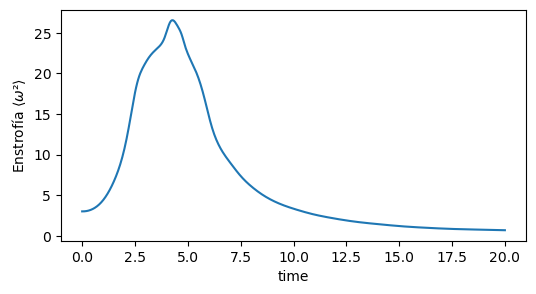

In [ ]:
data["enstrophy"].plot().set(ylabel="Enstrofía $\\langle ω² \\rangle$")

Podemos calcular la variación de energía como
$$\frac{dE}{dt} = -2 \, \nu \, \omega$$

(¿CÓMO JUSTIFICAMOS ESTO? ADEMÁS LA CUENTA DE ABAJO ES DISTINTO A ESTO) 

In [ ]:
nu = 3.5e-3
dEdt = -nu * data["enstrophy"]

ε = dEdt.min()
ε

-0.09294152198996775

In [ ]:
kη = (np.abs(ε) / nu**3) ** (1/4)

kη

38.37084928152247

### (c)
> Durante el máximo de enstrofía,
grafique el espectro de energía en escala log-log.
GHOST guarda estos espectros en los archivos `‘kspectrum.*.txt’`
(Ayuda: puede promediar varios espectros en el tiempo para reducir las fluctuaciones).
Identifique los números de onda relevantes,
y grafique como referencia una ley de potencias de Kolmogorov.
¿Obtiene el resultado esperado?
Interprete.

In [ ]:
dt_spectrum = 0.7
t_max = data["enstrophy"].idxmax()

index = t_max / dt_spectrum
index = int(index) + 1
index

7

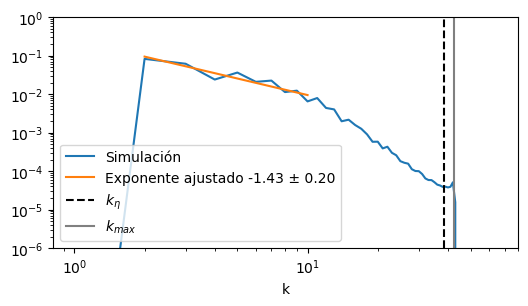

In [ ]:
def read_spectrum(path, num):
    path = Path(path)
    k, data = np.loadtxt(path / f"kspectrum.{num:04}.txt").T
    k = pd.Series(k, name="k")
    return pd.Series(data=data, index=k, name="spectrum")


spectrum = read_spectrum("problema4/output", index)
ax = spectrum.plot(label="Simulación")

corte = spectrum.loc[2:10]
x, y = corte.index, corte.values
p, cov = np.polyfit(np.log(x), np.log(y), 1, cov=True)
k, dk = p[0], cov[0, 0] ** 0.5
plt.plot(
    x,
    np.exp(np.polyval(p, np.log(x))),
    label=f"Exponente ajustado {k:.2f} ± {dk:.2f}",
)

ax.set(xscale="log", yscale="log", ylim=(1e-6, 1))
ax.axvline(kη, color="black", linestyle="--", label="$k_η$")
ax.axvline(k_max, color="gray", label="$k_{max}$")
ax.legend()

En el rango inercial,
esperamos que el espectro decaiga como $k^{-5/3}$,
según la ley de potencias de Kolmogorov.
Realizando un ajuste,
obtenemos un exponente compatible con dicho valor.

### (d)
> En los archivos `‘ktransfer.*.txt’`,
GHOST guarda la función de transferencia $T(k)$.
Utilice estos archivos para calcular el flujo de energía
$ Π(K) = − ∑_{k=0}^K T(k) $
durante el máximo de enstrofía.
¿Qué signo tiene el flujo?
Grafique $Π(K)$ en escala lin–log.
Interprete.

[None,
 Text(0, 0.5, 'Flujo de energía $\\Pi(K)$'),
 Text(0.5, 0, 'Número de onda k')]

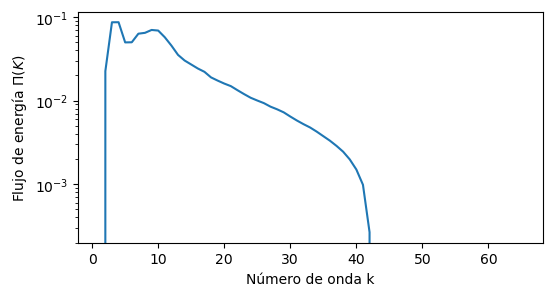

In [ ]:
def read_transfer(path, num):
    path = Path(path)
    k, data = np.loadtxt(path / f"ktransfer.{num:04}.txt").T
    k = pd.Series(k, name="k")
    return pd.Series(data=data, index=k, name="transfer")


transfer = read_transfer("problema4/output", 7)
pi = -transfer.cumsum()
pi.plot().set(
    yscale="log",
    ylabel="Flujo de energía $\Pi(K)$",
    xlabel="Número de onda k",
)

El flujo de energía tiene signo positivo,
que indica que la energía fluye de las escalas mayores a las menores.
En el rango inercial,
donde el espectro decae como $k^{-5/3}$,
el flujo de energía es aproximadamente constante.
Es decir,
toda la energía pasa a escalas menores.
En cambio,
para escalas más chicas,
empieza a ser más importante la disipación.

(ESTO ME GENERA DUDAS)

### (e)
> Grafique el decaimiento de la energía cinética $E(t)$ en escala log-log.
¿Qué espera obtener?
Compare los resultados con los obtenidos en el Problema 2.

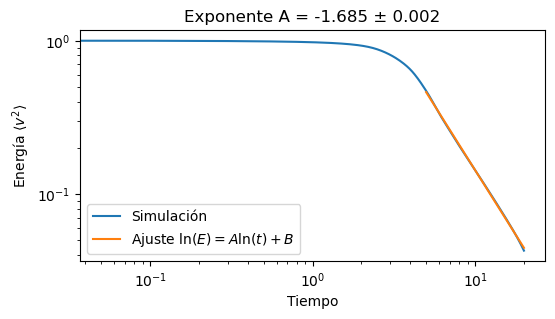

In [ ]:
data["energy"].plot(label="Simulación").set(
    xscale="log",
    yscale="log",
    xlabel="Tiempo",
    ylabel=r"Energía $\langle v^2 \rangle$",
)

e = data["energy"].loc[5:]
x, y = e.index, e.values
p, cov = np.polyfit(np.log(x), np.log(y), 1, cov=True)
plt.plot(x, np.exp(np.polyval(p, np.log(x))), label="Ajuste $\ln(E) = A \ln(t) + B$")

k, dk = p[0], cov[0, 0] ** 0.5
plt.title(f"Exponente A = {k:.3f} ± {dk:.3f}")
plt.legend()

En el caso de un flujo autosemejante,
esperabamos que el exponente del decaimiento sea $-2$,
que difiere del obtenido.

### (f)
> Utilizando la componente $x$ del campo de velocidad en un instante cercano al máximo de enstrofía,
calcule la función de estructura de segundo orden
> $$ S₂(r) = \Big\langle[uₓ(x + r x̂) − uₓ(x)]²\Big\rangle $$
> donde el valor medio es espacial sobre la coordenada $x$
(es decir, sobre todos los puntos del recinto).
Grafique $S₂(r)$ en escala log–log.
¿Obtiene el resultado esperado? ¿Por qué?

In [ ]:
vx = open_dataarray(
    "problema4/output",
    name="vx",
    dt=1.4,
    shape=(128, 128, 128),
    dtype=np.float32,
)
vx

<xarray.DataArray 'vx' (t: 15, x: 128, y: 128, z: 128)>
dask.array<concatenate, shape=(15, 128, 128, 128), dtype=float32, chunksize=(1, 128, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.0 0.04909 0.09817 0.1473 ... 6.087 6.136 6.185 6.234
  * y        (y) float64 0.0 0.04909 0.09817 0.1473 ... 6.087 6.136 6.185 6.234
  * z        (z) float64 0.0 0.04909 0.09817 0.1473 ... 6.087 6.136 6.185 6.234
  * t        (t) float64 0.0 1.4 2.8 4.2 5.6 7.0 ... 14.0 15.4 16.8 18.2 19.6

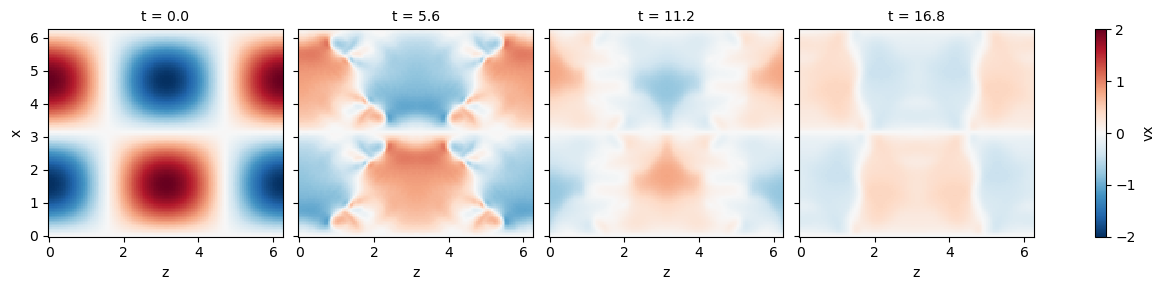

In [ ]:
vx.isel(y=64, t=slice(0, 16, 4)).plot(col="t")

In [ ]:
import dask
from dask.diagnostics import ProgressBar


def second_order_structure(vx, r):
    diff = vx.roll(x=r) - vx
    return (diff**2).mean()


vx0 = vx.sel(t=5, method="nearest")
r = np.arange(vx0.x.size)
S2 = [second_order_structure(vx0, ri) for ri in r]

with ProgressBar():
    (S2,) = dask.compute(S2)
S2 = np.array(S2)

[########################################] | 100% Completed | 8.56 sms


Text(0.5, 0, 'r')

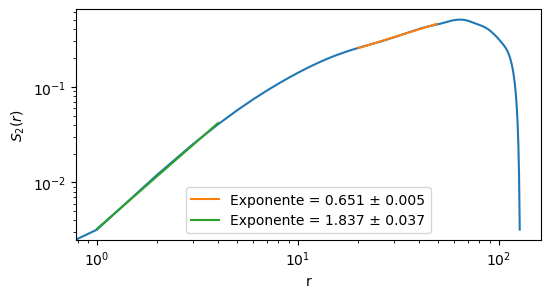

In [ ]:
def fit(x0, x1):
    ix = slice(x0, x1)
    p, cov = np.polyfit(np.log(r[ix]), np.log(S2[ix]), 1, cov=True)
    k, dk = p[0], cov[0, 0] ** 0.5
    plt.plot(
        r[ix],
        np.exp(np.polyval(p, np.log(r[ix]))),
        label=f"Exponente = {k:.3f} ± {dk:.3f}",
    )

plt.loglog(r, S2)
fit(20, 50)
fit(1, 5)
plt.legend()

plt.ylabel("$S_2(r)$")
plt.xlabel("r")

Obtenemos que,
en el rango inercial,
la función de escrutctura crece con un exponente $∼⅔$,
que es lo que propone Kolmogorov en su artículo de 1941
(Davidson P. A., *"Turbulence in Rotating, Stratified and Electrically Conducting Fields"*, p. 272).